In [34]:
import json
from math import sqrt, log2, pow
import math
import random
import matplotlib.pyplot as plt
import time
import numpy as np

In [35]:
H = 10
V = 20
T = 20
t = 0.5
d = V*t
X = 20
Y = 10
w_s = [5, 0]
w_d = [15, 0]
q_I = [0, 10]
q_F = [20, 10]
N = int(T/t)
N1 = N + 1

ro = 0.012
s = 0.05
A = 0.8
om = 100
R = 0.08
I = 0.1
p = 1.225
W = 0.5
v_0 = 7.2
d_0 = 0.0151/s/A
e = math.e
E = 0.5772156649
alpha = 2.2
a2 = alpha/2
B = 20
w_0 = 10**(-3)

xichma = 0.7
n_u = 0.5
P_u = 5  # 7.5 mW
P_b = 10**(-3)
P_s = 10**(1.6)  # 16dBm
xich_ma_u = 10**(-6)
nguy = 0.5
P_wpt = 1*10**7
S = 50
micro = 0.84

v_0 = sqrt(W / (2 * p * A))

P_0 = ro / 8 * p * s * A * om**3 * R ** 3
k_1 = 3 / om**2 / R**2
P_1 = (1 + I) * W**1.5 / sqrt(2*p*A)
k_2 = 1 / 2 / v_0**2
k_3 = 0.5 * d_0 * p * s * A
theta = e**(-E) * w_0 / xich_ma_u
print(P_0, P_1, k_1, k_2, k_3,theta)
print(v_0)

0.03763200000000001 0.277791949751858 0.04687499999999999 1.9600000000000004 0.00924875 561.4594835677459
0.5050762722761053


In [36]:
P_u_bar  = 10

In [37]:

def distance2(x, y):
    return (x[0]-y[0])**2 + (x[1]-y[1])**2


def distance(x, y):
    return sqrt(distance2(x, y))



In [38]:
def e_h(q):
    e_h = 0
    for i in range(0,len(q)-1):
        e_h_i = micro*(1 - q[i][2])*t*w_0*P_wpt/(H**2 + distance2([q[i][0]*20,q[i][1]*10], w_s))**a2
        e_h = e_h + e_h_i
    return e_h

In [39]:
def e_c(q):
    e_fly = 0
    for i in range(0,len(q)-1):
        dis = distance([q[i+1][0]*20,q[i+1][1]*10],[q[i][0]*20,q[i][1]*10])
        e_fly_i = P_0 * (t + k_1 * dis**2) + P_1 * sqrt(sqrt(t**4 + k_2**2 * dis**4) -
                                                        k_2 * dis**2) + k_3 * dis**3 / t**2 + q[i][2] * t * (P_b + P_u)
        e_fly = e_fly + e_fly_i
    return e_fly
    

In [40]:
def rate(q):
    r_u = 0  # total rate from source -> uav
    r_d = 0  # total rate from uav -> destination
    for i in range(0, len(q) - 1):
        d_su2 = distance2([q[i][0]*20,q[i][1]*10], w_s)  # distance^2 from uav to source
        d_du2 = distance2([q[i][0]*20,q[i][1]*10], w_d)  # distance^2 from uav to destination

        # R_u at time slot i
        # formula (20)
        r_u_i = log2(1 + (theta * P_s) / ((H**2 + d_su2)**a2))
        r_u = r_u + 1 * q[i][2] * t * r_u_i

        _o = ((H**2 + d_su2)**a2 * (H**2 + d_du2)**a2)
        # formula (21)
        r_d_i1 = log2(1+(theta*(n_u*w_0*P_s+P_u_bar*(H**2 + d_su2)**a2)) / _o)

        # Data transmission rate from UAV to d if it cached a part of f file
        r_d_i2 = log2(1 + theta * P_u / (H**2 + d_du2)**a2)
        # R_d at time slot i
        r_d_i = r_d_i1
        # r_d_i = r_d_i1 + r_d_i2
        r_d = r_d + 1 * q[i][2] * t * r_d_i
    return r_u+xichma*S,r_d

In [41]:
def rate1(q):
    r_u = 0  # total rate from source -> uav
    r_d = 0  # total rate from uav -> destination
    for i in range(0, len(q) - 1):
        d_su2 = distance2(q[i], w_s)  # distance^2 from uav to source
        d_du2 = distance2(q[i], w_d)  # distance^2 from uav to destination

        # R_u at time slot i
        # formula (20)
        r_u_i = log2(1 + (theta * P_s) / ((H**2 + d_su2)**a2))
        r_u = r_u + 1 * q[i][2] * t * r_u_i

        _o = ((H**2 + d_su2)**a2 * (H**2 + d_du2)**a2)
        # formula (21)
        r_d_i1 = log2(1+(theta*(n_u*w_0*P_s+P_u_bar*(H**2 + d_su2)**a2)) / _o)

        # Data transmission rate from UAV to d if it cached a part of f file
        r_d_i2 = log2(1 + theta * P_u / (H**2 + d_du2)**a2)
        # R_d at time slot i
        r_d_i = r_d_i1
        # r_d_i = r_d_i1 + r_d_i2
        r_d = r_d + 1 * q[i][2] * t * r_d_i
    return r_u+xichma*S,r_d

In [42]:
def fitness(q):
    return - rate(q)[1]

In [43]:
class Particle: 
    def __init__(self, N): 
        q = init_q1(N)
        self.position = init_q1(N)
        # need to normalize
        self.velocity = [[0.0,0.0, 0.0] for value in self.position]
        # compute fitness of particle
        self.fitness = fitness(self.position) # curr fitness
 
        # initialize best position and fitness of this particle
        self.best_part_pos = self.position
        self.best_part_fitnessVal = self.fitness # best fitness


In [44]:
def position(N):
        q = []
        for i in range(N + 1):
            q.append([0, 0, 0.1])
        qI = [0.0, 1.0, 0]
        q[0] = qI
        m = int(random.uniform(int(0.1 * N), int(0.9 * N)))
        cut = random.uniform(0.1, 0.9)
        q[m] = [cut, 0, 0]
        for i in range(m):
            delta_x = cut / m
            delta_y = 1 / m
            q[i][0] = i * delta_x
            q[i][1] = 1 - i * delta_y
        for i in range(m + 1, N):
            delta_x = (1 - cut) / (N - m)
            delta_y = 1 / (N - m)
            q[i][0] = cut + (i - m) * delta_x
            q[i][1] = (i - m) * delta_y
        q[N][0] = 1.0
        q[N][1] = 1.0
        for i in range(1, N + 1):
            temp =  micro*t*w_0*P_wpt
            Xi = temp / ((H**2 + distance2([q[i][0]*20,q[i][1]*10], w_s))**a2)
            e_con = e_c(q[0:i])
            e_har = e_h(q[0:i])
            delta_E_need = (e_con - e_har)*1.05
            max_tau =  1 - (delta_E_need / Xi)
            threshold = min(max_tau, 1)
            if threshold > 0:
                tau = random.uniform(threshold*0.95, threshold)
            else:
                print("Khong du nang luong tai slot thu: ", i)
                break
            q[i][2] = tau

        return q

In [45]:
#check lai all constrainst
def init_q1(N):
    q = position(N)
    if check_constrainst_place(q) == 0:
        print("Vi pham rang buoc 1")
    if check_constrainst_tau(q) == 0:
        print("Vi pham rang buoc 2")
    if check_constrainst_distance(q) == 0:
        print("Vi pham rang buoc 3")
    if check_constrainst_energy(q) == 0:
        print("Vi pham rang buoc 4")     
    data1 = rate(q)[1]
    data2 = rate(q)[0]
    if data1 > data2:
        print("rang buoc 5")
    
    #print("UAV", data2)
    while check_all_constrainst(q) == 0:
        print("Vi pham rang buoc: thu lai")
        q = position(N)
    print("Des ",data1)
    return q 

In [46]:
def check_constrainst_tau(q):#22g
    for q_i in q:
        if q_i[2] < 0:
            return 0
        if q_i[2] > 1:
            return 0
        return 1
def check_constrainst_energy(q):#22d
    q_ = []
    q_.append(q[0])
    for i in range (1,len(q)-1):
        q_.append(q[i])
        E_consump = e_c(q)
        E_harvest = e_h(q)
        if E_consump > E_harvest:
            return 0
    return 1
def check_constrainst_distance(q):#22e
    #q.len()
    for i in range (0,len(q) - 1):
        if(distance([q[i][0]*20,q[i][1]*10],[q[i+1][0]*20,q[i+1][1]*10])) > d:
            return 0
    return 1
def check_constrainst_place(q):#22f
    if q[0][0] != 0.0:
        return 0
    if q[0][1] != 1.0:
        return 0
    if q[-1][0] != 1.0:
        return 0
    if q[-1][1] != 1.0:
        return 0
    for q_ in q:
        if (q_[0] < 0) or (q_[0] > 1):
            return 0
        if (q_[1] < 0) or (q_[1] > 1):
            return 0
        if (q_[2] < 0) or (q_[2] > 1):
            return 0
    return 1
def check_constrainst_data(q): ##constraint 22b and 22c
    return  rate(q)[1] < rate(q)[0]

In [47]:
xw = position(N)

In [48]:
e_c(xw)

89.66954693339545

In [49]:
e_h(xw)

89.82876542415396

In [50]:
def check_all_constrainst(q):
    if check_constrainst_place(q) == 0:
        return 0
    if check_constrainst_tau(q) == 0:
        return 0
    if check_constrainst_distance(q) == 0:
        return 0
    if check_constrainst_energy(q) == 0:
        return 0      
    if check_constrainst_data(q) == 0:
        return 0
    return 1

In [51]:
def extract_x(q):
  return [item[0] for item in q]

def extract_z(q):
  return [item[2] for item in q]
def extract_y(q):
  return [item[1] for item in q]

def show_figure(q):
    x_coor = extract_x(q)
    y_coor = extract_y(q)
    plt.plot(x_coor, y_coor)
    plt.show()
def show_fig_tau(q):
    z_coor = extract_z(q)
    plt.plot(z_coor)
    plt.show()


In [52]:
def fix1_position(q):
    
    return q
def fix_position(q):
    
    while(check_constrainst_energy(q) == 0):
        for i in range(1,len(q)):
            if e_c(q[1:i])> e_h(q[1:i]):
                for j in range(1,i+1):
                    q[j][2] = q[j][2]*0.95
    return q

In [70]:
def find_slot(q):
    r_d =[]
    e_h = []
    dict = {}
    for i in range(0, len(q) - 1):
        r_d.append(1)
        e_h.append(1)
    for i in range(1,len(q) - 1):
        d_su2 = distance2([q[i][0]*20,q[i][1]*10], w_s)  # distance^2 from uav to source
        d_du2 = distance2([q[i][0]*20,q[i][1]*10], w_d)
        _o = ((H**2 + d_su2)**a2 * (H**2 + d_du2)**a2)
        # formula (21)
        r_d[i] = log2(1+(theta*(n_u*w_0*P_s+P_u_bar*(H**2 + d_su2)**a2)) / _o)
        e_h[i] = micro*(1 - q[i][2])*t*w_0*P_wpt/(H**2 + distance2([q[i][0]*20,q[i][1]*10], w_s))**a2
        if e_h[i] == 0:
            continue
        dict[i] = r_d[i]/e_h[i]
    
    return sorted(dict.items(), key=lambda x: x[1], reverse=True)


In [71]:
def enhance(q):
    dict = find_slot(q)
   
    print('dict type',type(dict))
    while(e_h(q)>e_c(q)):
        for i in range (0,len(dict) - 1):
            j = dict[i][0]
            print(j)
            e_h_rate = micro*t*w_0*P_wpt/(H**2 + distance2([q[i][0]*20,q[i][1]*10], w_s))**a2
            delta_E = e_h(q) - e_c(q)
            m = min(0.05,e_h_rate*0.5)
            if delta_E <= e_h_rate*0.5: 
                break
            tmp = delta_E/e_h_rate
            if tmp > 1 - q[j][2]:
                q[j][2] = 1
            else:
                q[j][2] = q[j][2] + tmp
        
                
    return q


In [55]:
def pso(max_iter, n, dim, min_v, max_v,w,c1,c2):
    # hyper parameters
    w = w # inertia
    c1 = c1# cognitive (particle)
    c2 = c2 # social (swarm)

    rnd = random.Random(0)

    # create n random particles
    print("Create Swarm")
    swarm = [Particle(dim) for i in range(n)]
    # compute the value of best_position and best_fitness in swarm
    best_swarm_pos = swarm[0]
    best_swarm_fitnessVal = 99.99  # swarm best

    #compute best particle of swarm and it's fitness
    for i in range(n):  # check each particle
        if swarm[i].fitness < best_swarm_fitnessVal:
            best_swarm_fitnessVal = swarm[i].fitness
            best_swarm_pos = swarm[i].position
    print("Before start PSO")
    print("Best fitness",best_swarm_fitnessVal)
    show_figure(best_swarm_pos)
    # main loop of pso
    Iter = 0
    while Iter < max_iter:

        # after every 10 iterations
        # print iteration number and best fitness value so far
        if Iter % 10 == 0 and Iter > 1:
            print("Iter = " + str(Iter) + " best fitness = %.3f" % best_swarm_fitnessVal)
        if Iter % 10 == 0 and Iter > 1:
            print("Iter = " + str(Iter) + " best fitness = %.3f" % best_swarm_fitnessVal)   
            show_figure(best_swarm_pos)

        for i in range(n):  # process each particle

            # compute new velocity of curr particle
            for k in range(dim):
                r1 = rnd.random()  # randomizations
                r2 = rnd.random()
                for l in range(0, 3):
                    swarm[i].velocity[k][l] = (
                            (w * swarm[i].velocity[k][l]) +
                            (c1 * r1 * (swarm[i].best_part_pos[k][l] - swarm[i].position[k][l])) +
                            (c2 * r2 * (best_swarm_pos[k][l] - swarm[i].position[k][l]))
                    )
                    #print("new v",swarm[i].velocity[k][l])
                    # if velocity[k] is not in [minx, max]
                    # then clip it
                    if swarm[i].velocity[k][l] < min_v:
                        swarm[i].velocity[k][l] = min_v
                    elif swarm[i].velocity[k][l] > max_v:
                        swarm[i].velocity[k][l] = max_v

            # compute new position using new velocity
            for k in range(dim):
                for l in range(0, 3):
                    swarm[i].position[k][l] += swarm[i].velocity[k][l]
                    if swarm[i].position[k][l] > 1:
                        swarm[i].position[k][l] = 0.98
                    #if swarm[i].position[k][l] < 0:
                        #swarm[i].position[k][l] = 0.02
                    
            #check constrainst and fix position
            check1 = check_constrainst_distance(swarm[i].position)
            check2 = check_constrainst_energy(swarm[i].position)
            if check1*check2 == 0:
                fix_position(swarm[i].position)
            # compute fitness of new position
            swarm[i].fitness = fitness(swarm[i].position)
            # is new position a new best for the particle?
            if swarm[i].fitness < swarm[i].best_part_fitnessVal:
                swarm[i].best_part_fitnessVal = swarm[i].fitness
                swarm[i].best_part_pos = swarm[i].position

            # is new position a new best overall?
            if swarm[i].fitness < best_swarm_fitnessVal:
                #swarm[i].position = enhance(swarm[i].position)
                best_swarm_fitnessVal = swarm[i].fitness
                best_swarm_pos = swarm[i].position

        # for-each particle
        Iter += 1
    # end_while
    return best_swarm_pos
# end pso


In [60]:
num_particles = 100
max_iter = 1000
print("Setting num_particles = " + str(num_particles))
print("Setting max_iter    = " + str(max_iter))
print("\nStarting PSO algorithm\n")

Setting num_particles = 100
Setting max_iter    = 1000

Starting PSO algorithm



Create Swarm
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Des  71.65899959666831
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Des  70.98138431344343
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Des  70.49429082142949
Des  65.776983191337
Des  65.27428904565878
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Des  72.19015081855797
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Des  71.59889436016948
Khong du nang luong tai slot thu:  40
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Des  64.87565291544071

Des  70.80071651998658
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Des  71.81768832634128
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Des  67.97830729085747
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Des  72.95988109017877
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Des  71.2981315802015
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Des  62.88532156253488
Des  70.67087846654454
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Des  70.31075767453144
Des  66.66924232115855
Des  63.08764295317065
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Des  72.73058899219606
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Des  70.63907265683336
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Des  73.17400097133618
Vi pham rang buoc 4
Vi pham rang buoc: thu lai
Vi pham rang buoc: thu lai
Vi pham rang buo

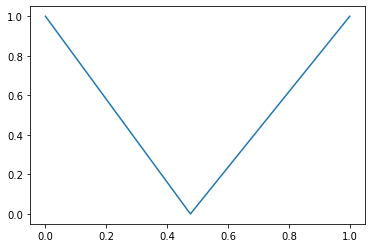

Iter = 10 best fitness = -73.334
Iter = 10 best fitness = -73.334


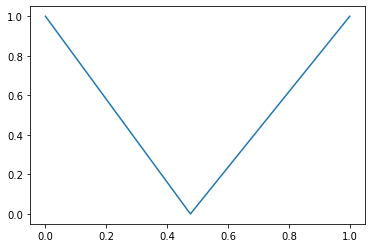

Iter = 20 best fitness = -73.366
Iter = 20 best fitness = -73.366


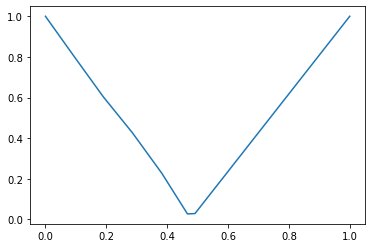

Iter = 30 best fitness = -73.454
Iter = 30 best fitness = -73.454


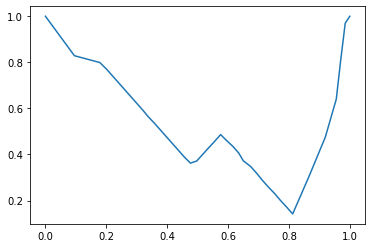

Iter = 40 best fitness = -73.655
Iter = 40 best fitness = -73.655


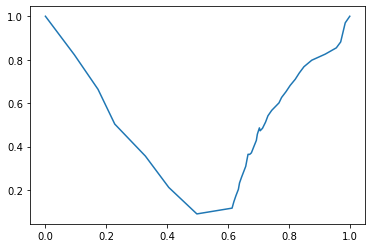

Iter = 50 best fitness = -73.687
Iter = 50 best fitness = -73.687


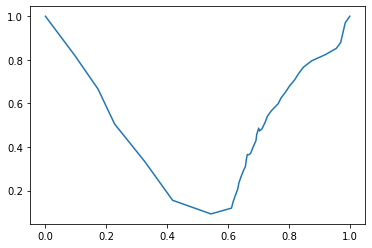

Iter = 60 best fitness = -73.802
Iter = 60 best fitness = -73.802


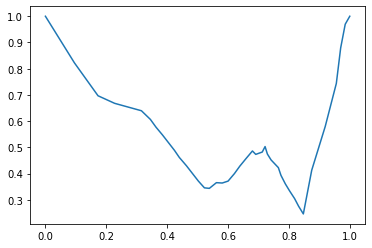

Iter = 70 best fitness = -73.817
Iter = 70 best fitness = -73.817


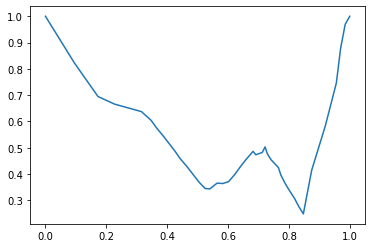

Iter = 80 best fitness = -73.817
Iter = 80 best fitness = -73.817


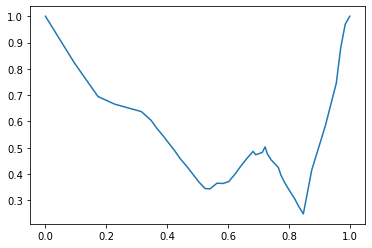

Iter = 90 best fitness = -73.817
Iter = 90 best fitness = -73.817


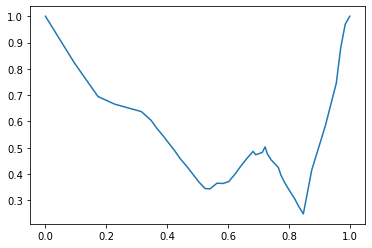

Iter = 100 best fitness = -73.817
Iter = 100 best fitness = -73.817


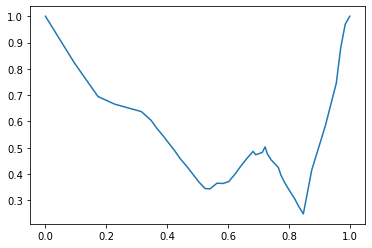

Iter = 110 best fitness = -73.817
Iter = 110 best fitness = -73.817


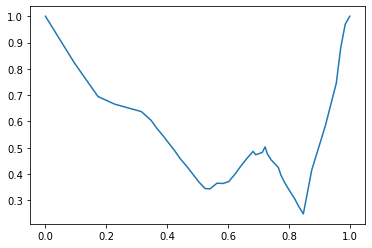

Iter = 120 best fitness = -73.817
Iter = 120 best fitness = -73.817


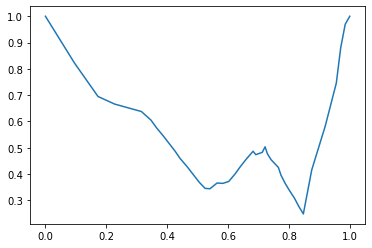

Iter = 130 best fitness = -73.828
Iter = 130 best fitness = -73.828


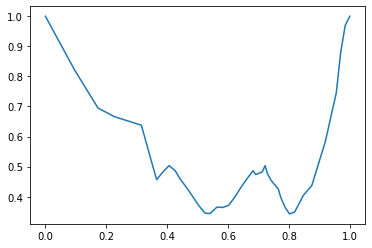

Iter = 140 best fitness = -73.847
Iter = 140 best fitness = -73.847


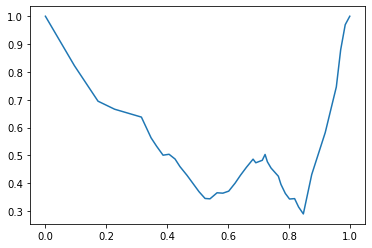

Iter = 150 best fitness = -73.923
Iter = 150 best fitness = -73.923


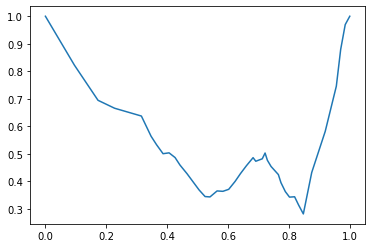

Iter = 160 best fitness = -74.014
Iter = 160 best fitness = -74.014


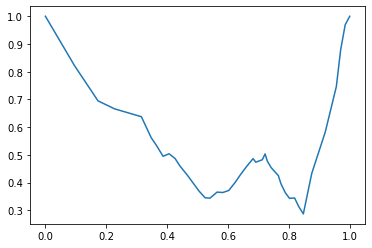

Iter = 170 best fitness = -74.100
Iter = 170 best fitness = -74.100


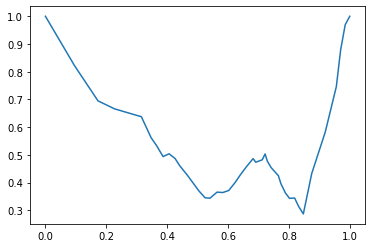

Iter = 180 best fitness = -74.185
Iter = 180 best fitness = -74.185


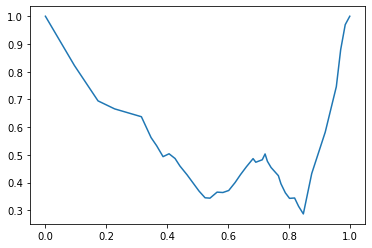

Iter = 190 best fitness = -74.278
Iter = 190 best fitness = -74.278


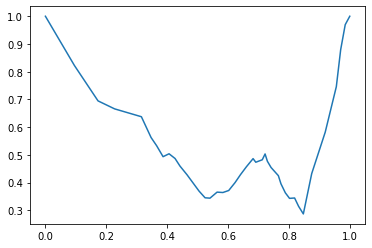

Iter = 200 best fitness = -74.364
Iter = 200 best fitness = -74.364


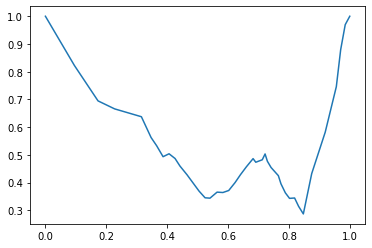

Iter = 210 best fitness = -74.451
Iter = 210 best fitness = -74.451


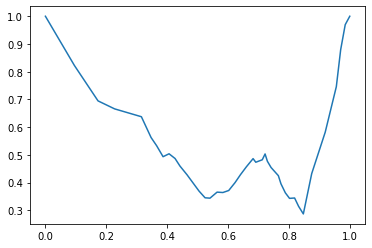

Iter = 220 best fitness = -74.540
Iter = 220 best fitness = -74.540


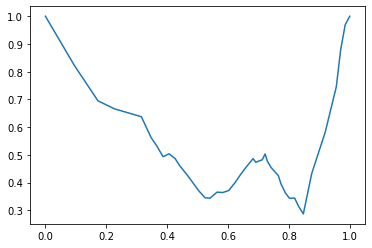

Iter = 230 best fitness = -74.598
Iter = 230 best fitness = -74.598


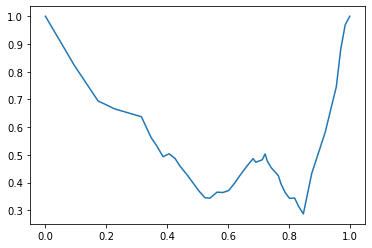

Iter = 240 best fitness = -74.598
Iter = 240 best fitness = -74.598


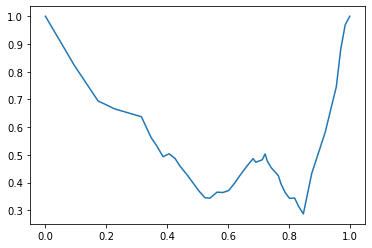

Iter = 250 best fitness = -74.598
Iter = 250 best fitness = -74.598


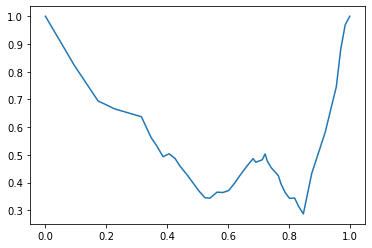

Iter = 260 best fitness = -74.598
Iter = 260 best fitness = -74.598


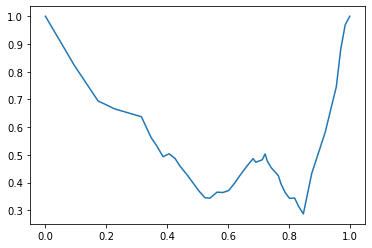

Iter = 270 best fitness = -74.598
Iter = 270 best fitness = -74.598


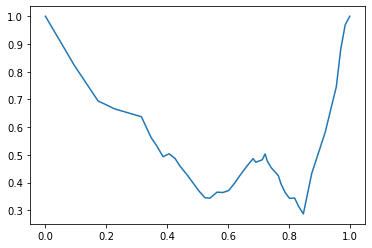

Iter = 280 best fitness = -74.598
Iter = 280 best fitness = -74.598


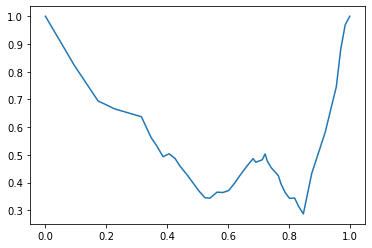

Iter = 290 best fitness = -74.598
Iter = 290 best fitness = -74.598


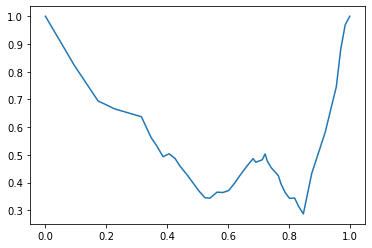

Iter = 300 best fitness = -74.598
Iter = 300 best fitness = -74.598


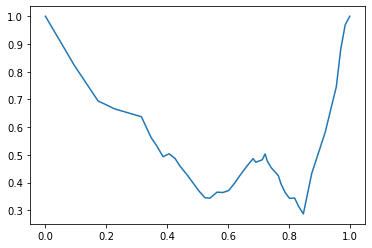

Iter = 310 best fitness = -74.598
Iter = 310 best fitness = -74.598


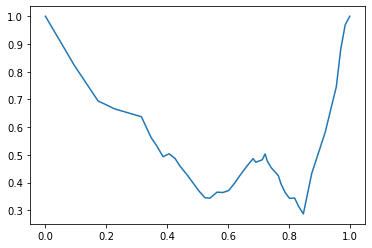

Iter = 320 best fitness = -74.598
Iter = 320 best fitness = -74.598


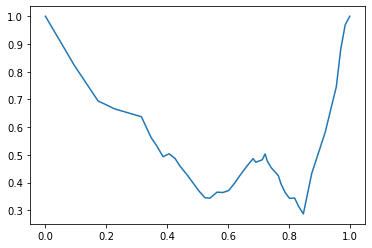

Iter = 330 best fitness = -74.598
Iter = 330 best fitness = -74.598


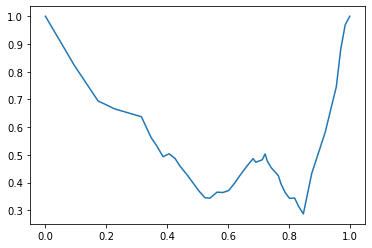

Iter = 340 best fitness = -74.598
Iter = 340 best fitness = -74.598


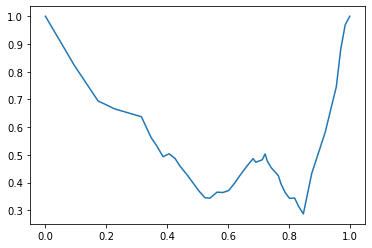

Iter = 350 best fitness = -74.598
Iter = 350 best fitness = -74.598


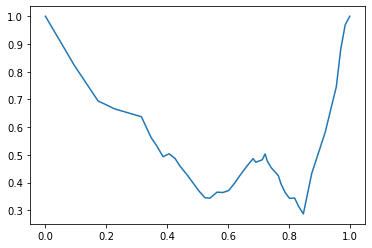

Iter = 360 best fitness = -74.598
Iter = 360 best fitness = -74.598


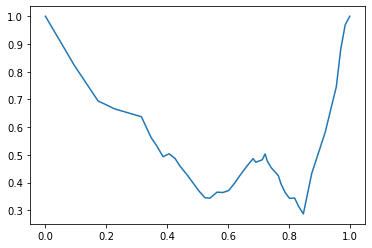

Iter = 370 best fitness = -74.598
Iter = 370 best fitness = -74.598


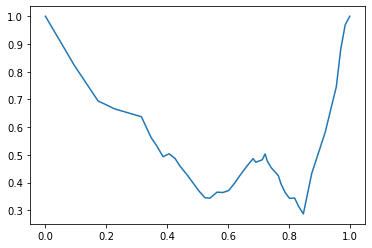

Iter = 380 best fitness = -74.598
Iter = 380 best fitness = -74.598


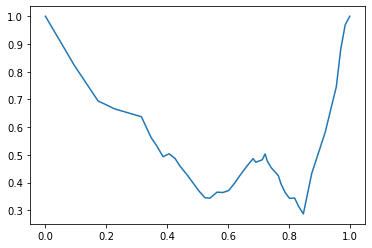

Iter = 390 best fitness = -74.598
Iter = 390 best fitness = -74.598


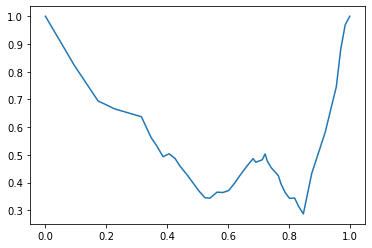

Iter = 400 best fitness = -74.598
Iter = 400 best fitness = -74.598


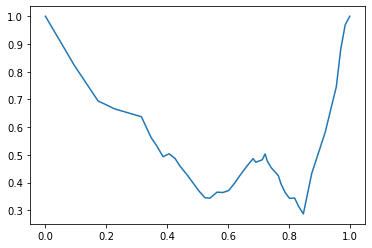

Iter = 410 best fitness = -74.598
Iter = 410 best fitness = -74.598


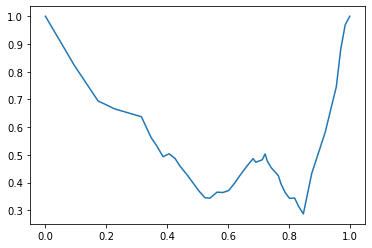

Iter = 420 best fitness = -74.598
Iter = 420 best fitness = -74.598


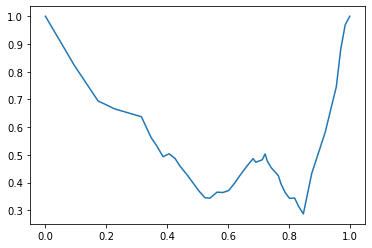

Iter = 430 best fitness = -74.598
Iter = 430 best fitness = -74.598


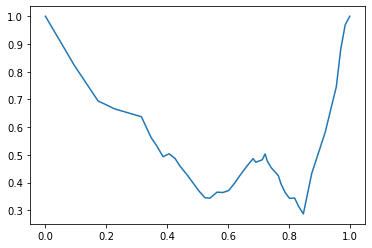

Iter = 440 best fitness = -74.598
Iter = 440 best fitness = -74.598


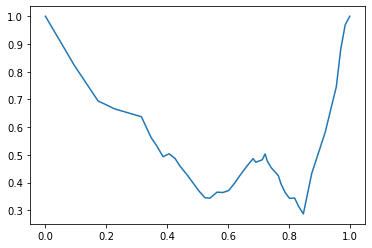

Iter = 450 best fitness = -74.598
Iter = 450 best fitness = -74.598


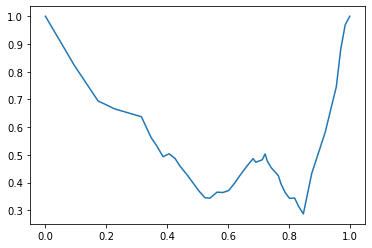

Iter = 460 best fitness = -74.598
Iter = 460 best fitness = -74.598


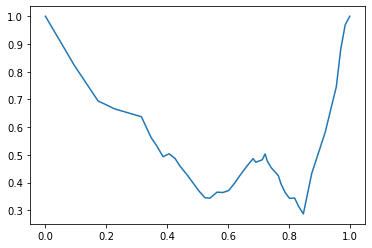

Iter = 470 best fitness = -74.598
Iter = 470 best fitness = -74.598


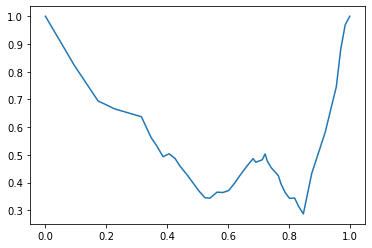

Iter = 480 best fitness = -74.598
Iter = 480 best fitness = -74.598


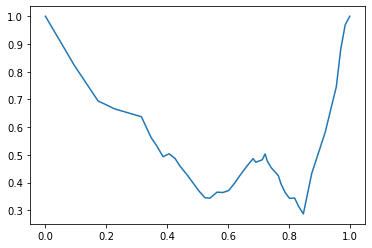

Iter = 490 best fitness = -74.598
Iter = 490 best fitness = -74.598


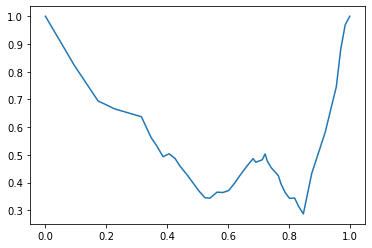

Iter = 500 best fitness = -74.598
Iter = 500 best fitness = -74.598


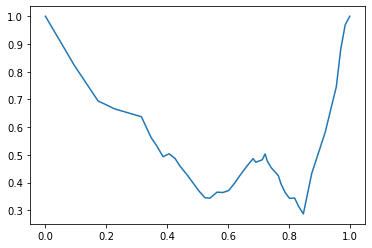

Iter = 510 best fitness = -74.598
Iter = 510 best fitness = -74.598


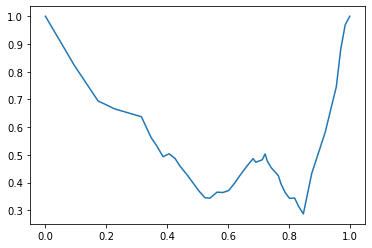

Iter = 520 best fitness = -74.598
Iter = 520 best fitness = -74.598


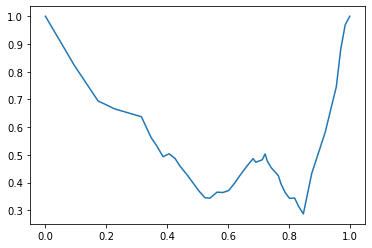

Iter = 530 best fitness = -74.598
Iter = 530 best fitness = -74.598


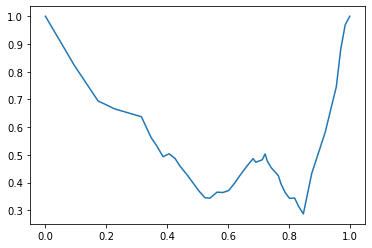

Iter = 540 best fitness = -74.598
Iter = 540 best fitness = -74.598


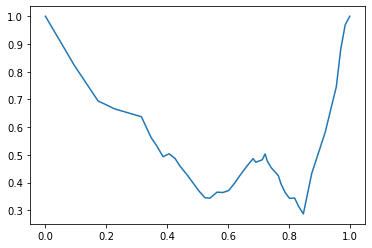

Iter = 550 best fitness = -74.598
Iter = 550 best fitness = -74.598


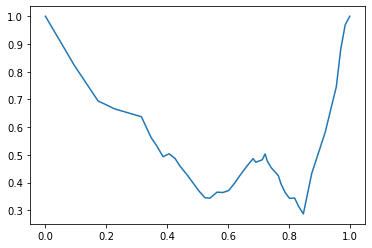

Iter = 560 best fitness = -74.598
Iter = 560 best fitness = -74.598


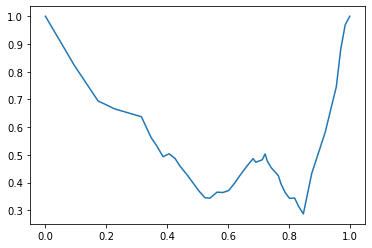

Iter = 570 best fitness = -74.598
Iter = 570 best fitness = -74.598


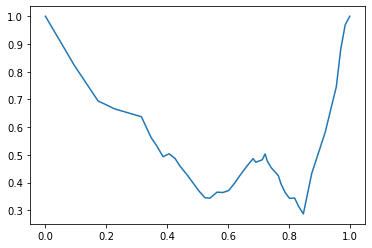

Iter = 580 best fitness = -74.598
Iter = 580 best fitness = -74.598


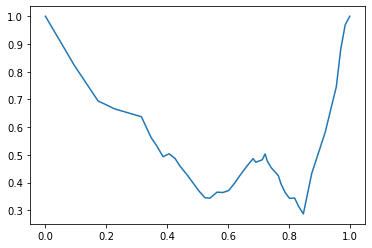

Iter = 590 best fitness = -74.598
Iter = 590 best fitness = -74.598


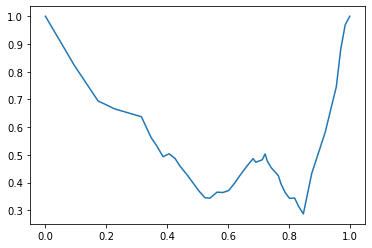

Iter = 600 best fitness = -74.598
Iter = 600 best fitness = -74.598


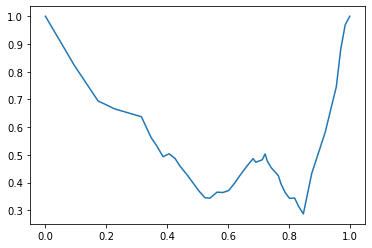

Iter = 610 best fitness = -74.598
Iter = 610 best fitness = -74.598


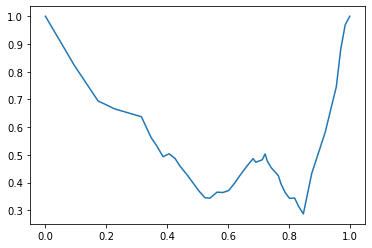

Iter = 620 best fitness = -74.598
Iter = 620 best fitness = -74.598


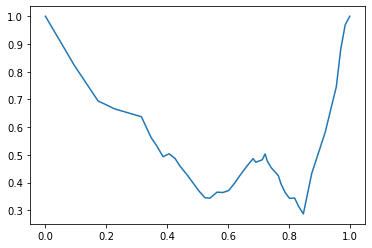

Iter = 630 best fitness = -74.598
Iter = 630 best fitness = -74.598


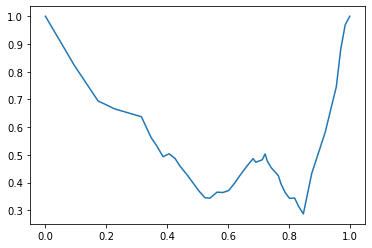

Iter = 640 best fitness = -74.598
Iter = 640 best fitness = -74.598


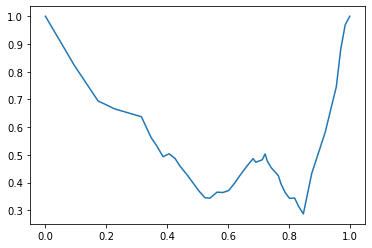

Iter = 650 best fitness = -74.598
Iter = 650 best fitness = -74.598


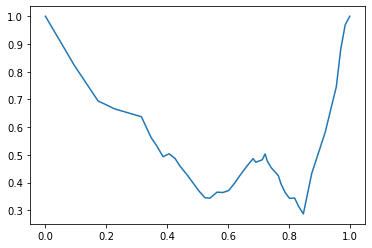

Iter = 660 best fitness = -74.598
Iter = 660 best fitness = -74.598


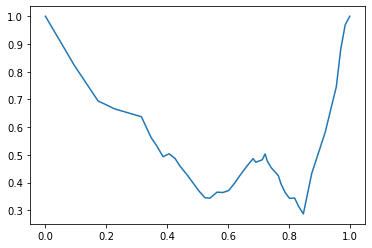

Iter = 670 best fitness = -74.598
Iter = 670 best fitness = -74.598


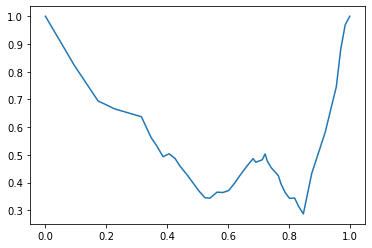

Iter = 680 best fitness = -74.598
Iter = 680 best fitness = -74.598


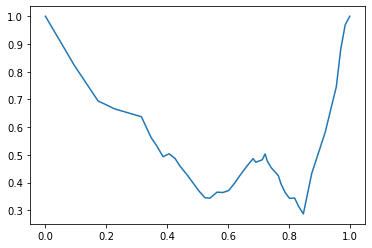

Iter = 690 best fitness = -74.598
Iter = 690 best fitness = -74.598


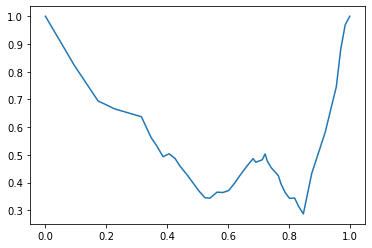

Iter = 700 best fitness = -74.598
Iter = 700 best fitness = -74.598


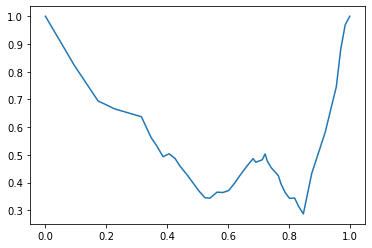

Iter = 710 best fitness = -74.598
Iter = 710 best fitness = -74.598


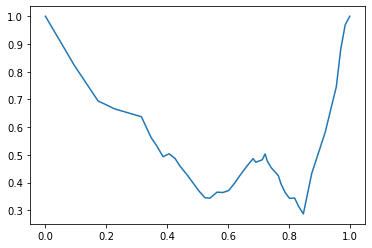

Iter = 720 best fitness = -74.598
Iter = 720 best fitness = -74.598


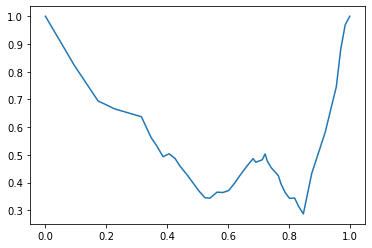

Iter = 730 best fitness = -74.598
Iter = 730 best fitness = -74.598


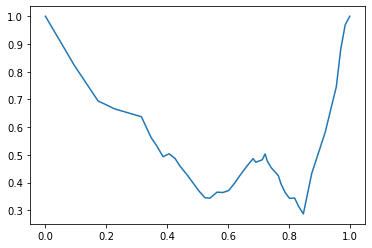

Iter = 740 best fitness = -74.598
Iter = 740 best fitness = -74.598


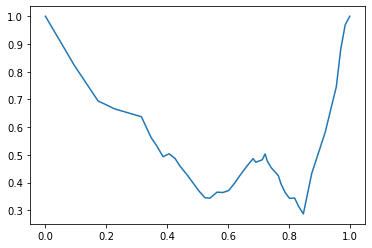

Iter = 750 best fitness = -74.598
Iter = 750 best fitness = -74.598


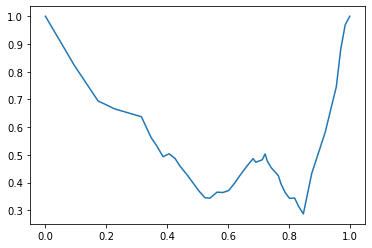

Iter = 760 best fitness = -74.598
Iter = 760 best fitness = -74.598


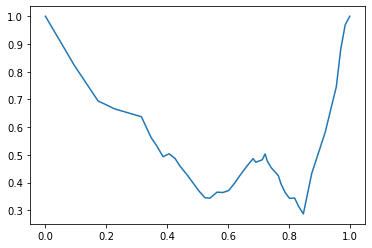

Iter = 770 best fitness = -74.598
Iter = 770 best fitness = -74.598


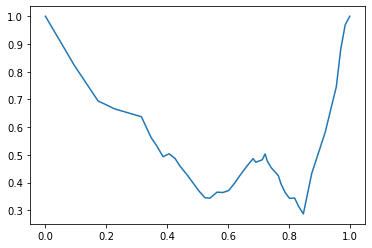

Iter = 780 best fitness = -74.598
Iter = 780 best fitness = -74.598


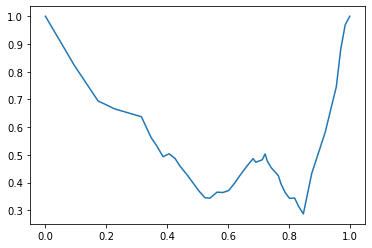

Iter = 790 best fitness = -74.598
Iter = 790 best fitness = -74.598


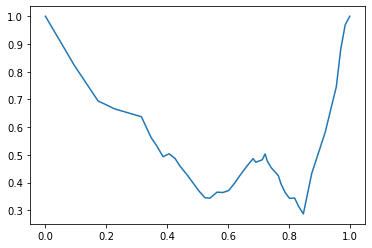

Iter = 800 best fitness = -74.598
Iter = 800 best fitness = -74.598


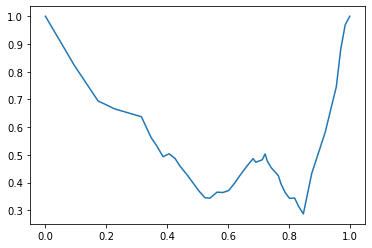

Iter = 810 best fitness = -74.598
Iter = 810 best fitness = -74.598


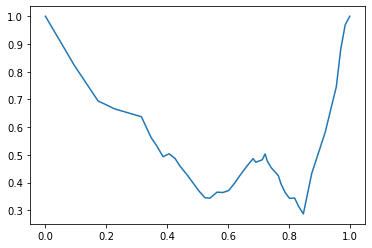

Iter = 820 best fitness = -74.598
Iter = 820 best fitness = -74.598


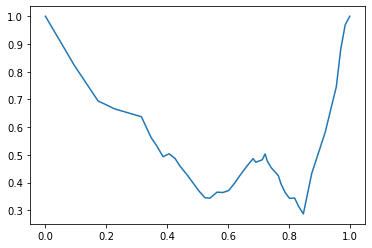

Iter = 830 best fitness = -74.598
Iter = 830 best fitness = -74.598


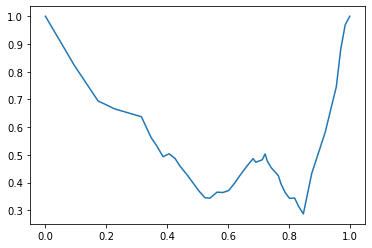

Iter = 840 best fitness = -74.598
Iter = 840 best fitness = -74.598


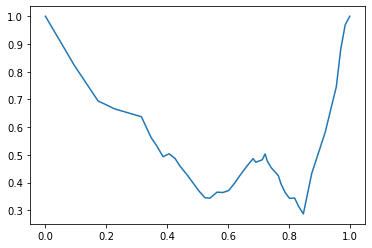

Iter = 850 best fitness = -74.598
Iter = 850 best fitness = -74.598


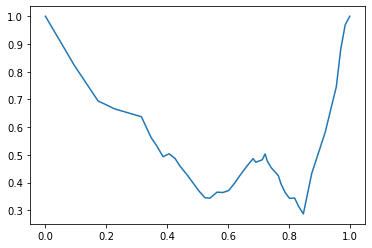

Iter = 860 best fitness = -74.598
Iter = 860 best fitness = -74.598


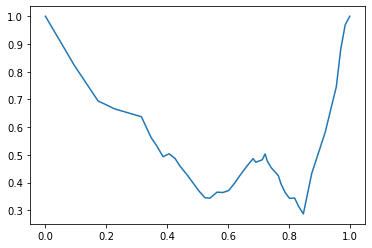

Iter = 870 best fitness = -74.598
Iter = 870 best fitness = -74.598


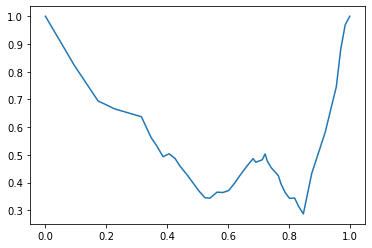

Iter = 880 best fitness = -74.598
Iter = 880 best fitness = -74.598


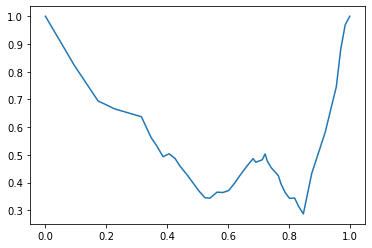

Iter = 890 best fitness = -74.598
Iter = 890 best fitness = -74.598


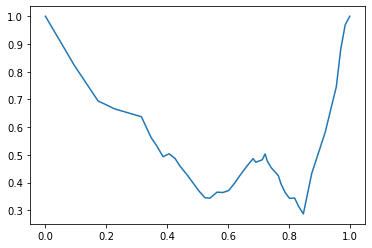

Iter = 900 best fitness = -74.598
Iter = 900 best fitness = -74.598


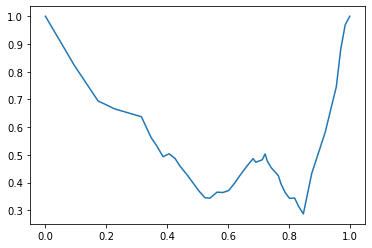

Iter = 910 best fitness = -74.598
Iter = 910 best fitness = -74.598


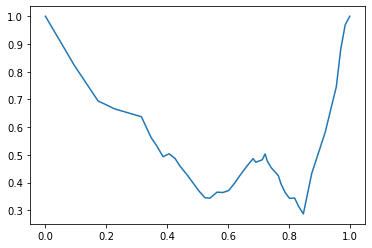

Iter = 920 best fitness = -74.598
Iter = 920 best fitness = -74.598


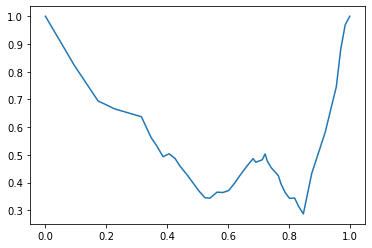

Iter = 930 best fitness = -74.598
Iter = 930 best fitness = -74.598


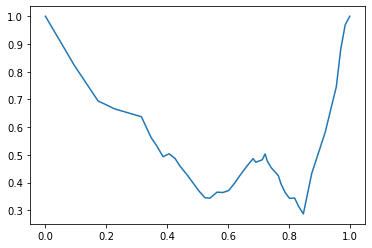

Iter = 940 best fitness = -74.598
Iter = 940 best fitness = -74.598


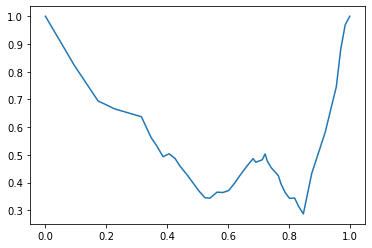

Iter = 950 best fitness = -74.598
Iter = 950 best fitness = -74.598


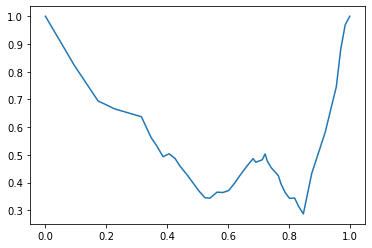

Iter = 960 best fitness = -74.598
Iter = 960 best fitness = -74.598


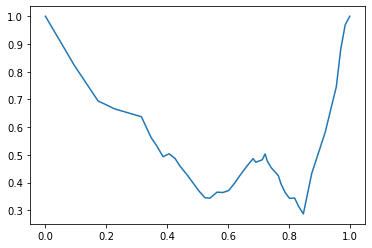

Iter = 970 best fitness = -74.598
Iter = 970 best fitness = -74.598


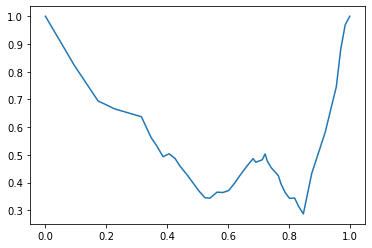

Iter = 980 best fitness = -74.598
Iter = 980 best fitness = -74.598


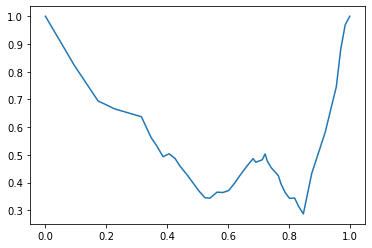

Iter = 990 best fitness = -74.598
Iter = 990 best fitness = -74.598


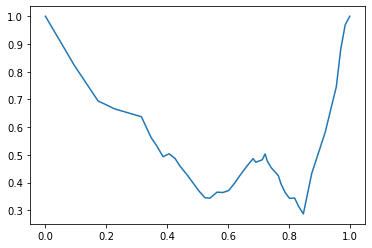


PSO completed


Best solution found:
[[0.0, 1.0, 0.0], [0.09529377980852008, 0.8223102681938188, 0.9604912990597507], [0.17284193417119864, 0.6946673279290337, 0.9770843716694239], [0.22732287177492166, 0.6658610017829457, 0.9574963426417324], [0.31530725767491774, 0.6375376387234856, 0.9520674312945808], [0.3470804093191122, 0.5625728352261579, 0.9739505403994494], [0.3653831120927633, 0.5329980398622716, 0.9477475372504844], [0.3865161703180248, 0.49332978898156415, 0.8044031480508183], [0.4062340509188953, 0.5038607551834196, 0.7160444665348493], [0.4259519310505403, 0.48680316795877016, 0.8071504076972524], [0.442062168179324, 0.45955724868950265, 0.8952588994050019], [0.46538769207119096, 0.42797958571441175, 0.9958166151067838], [0.4844014148174016, 0.3995888662264401, 0.975336625013034], [0.5048234527992782, 0.3691560516808208, 0.8295393672436494], [0.5245413332367748, 0.3450966531256745, 0.6688471603901274], [0.5407027318957641, 0.3437750252946477, 0.6994785496120525], [0.5639

In [61]:
best_position = pso(max_iter, num_particles, N, -0.005, 0.005,0.3,1.4,1.4)
 
print("\nPSO completed\n")
print("\nBest solution found:")

print(best_position)
fitnessVal = fitness(best_position)
print("fitness of best solution = %.6f" % fitnessVal)

In [72]:
best_position = enhance(best_position)
show_figure(best_position)
show_fig_tau(best_position)

dict type <class 'list'>
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36


36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
3

36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
3

36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
3

36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
3

36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
3

36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
3

36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
3

36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
3

36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
3

KeyboardInterrupt: 

In [33]:
print(rate(best_position))
print(e_c(best_position),e_h(best_position))
check_constrainst_distance(best_position)

(137.23136658143295, 75.36703297153025)
92.49565659645035 92.30294555405229


1

In [96]:
q = fix_position(best_position)
print(e_c(q),e_h(q))

96.84600127007378 97.8363401101346


In [30]:
x = [0.0,
 0.2011383951959218,
 0.4825657643781261,
 0.47614589750272135,
 0.415910363652145,
 0.2732300930005825,
 0.5461713119670782,
 0.5366642152899148,
 0.6130274236642942,
 0.5124368356871707,
 0.5479830378021644,
 0.5544357343456264,
 0.5077834875972475,
 0.6763367067848202,
 0.6040394707466229,
 0.5366253069278853,
 0.5890588046112637,
 0.52997828683562,
 0.5052457394268492,
 0.39557428507058684,
 0.3260695346811032,
 0.301720398784634,
 0.4676141145303815,
 0.47158908551293366,
 0.382836850148262,
 0.4342637516459325,
 0.3286004888462327,
 0.4706657773610483,
 0.6124882241511743,
 0.40112640849847303,
 0.32024629205642624,
 0.2814926002307965,
 0.5206197972301975,
 0.3864448062768895,
 0.5204104089044655,
 0.4064300157179347,
 0.505295725374081,
 0.6903868664228763,
 0.5913157374849389,
 0.7532687729188164,
 1.0,
 1.0,
 0.4063222940672809,
 0.43151510873715393,
 0.5143416718629672,
 0.33607228310317083,
 0.3983482220807748,
 0.2096488206153945,
 0.1230599512511545,
 0.43515164647765914,
 0.07194417409134662,
 0.1952816247568347,
 0.24111439445363828,
 0.4345737774849668,
 0.33865520729885196,
 0.45618117035113676,
 0.15856007626629487,
 0.34963765431149274,
 0.4581064290714744,
 0.640969983190894,
 0.4144460998306743,
 0.16999154195773203,
 0.1622496452649893,
 0.2614468643729988,
 0.5343989414707001,
 0.5124274810946048,
 0.4840480357779956,
 0.4101067163899135,
 0.6336098408598783,
 0.26035641662522746,
 0.2605073454120609,
 0.4717899344222419,
 0.6187473263327115,
 0.5799515319393941,
 0.4183645832756424,
 0.8388838163796914,
 0.3320776327879401,
 0.6420010007639517,
 0.41877398117488357,
 0.299956532960598,
 0.3930805376954681,
 1.0,
 0.4694443808981386,
 0.5396759133584129,
 0.651354124857496,
 0.9351890562944905,
 0.7812122515346521,
 0.7106334548291844,
 0.7739530473023397,
 0.6834045201528282,
 0.7196717313255547,
 0.8468200598480986,
 0.7241966216478363,
 0.6562379290614764,
 0.7428454868471227,
 0.8647894730106628,
 0.9151175879208139,
 0.772983199030026,
 0.6049100333314491,
 0.6495074640400811,
 0.6158000887331018,
 0.827967709610206,
 0.6314950150284258,
 0.7390353223928424,
 0.712897164242919,
 0.634976633789221,
 0.6333987698446706,
 0.7404760370769325,
 0.9108716769796682,
 0.7418341635808438,
 0.543214680329075,
 0.6072520553475488,
 0.4903705028262666,
 0.491932247099582,
 0.7683392825428002,
 0.4978619123026287,
 0.7738806197235341,
 0.7282007983566593,
 0.6694310668467655,
 0.7336986718553096,
 0.7169246165955626,
 0.7900853712681181,
 0.4276383717046692]

In [31]:
#convert tu phu sang cuong
def convert(x):
    x1 = 1
    x2 = 1
    x3 = 1
    q = []
    for i in range(0,41):
        x1  = x[i]*20
        x2 = x[i+41]*10
        x3 = x[i+82]
        q.append([x1,x2,x3])
    return q

In [32]:
q_check = convert(x)
rate1(q_check)

(127.10784545111588, 63.84238681306331)

In [33]:
print(rate(q_check))
print(e_c(q_check),e_h(q_check))

(39.7059347841681, 1.515593112341419)
398227.95577417366 0.7432242903716886


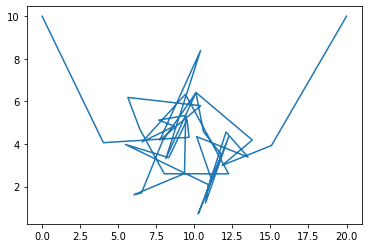

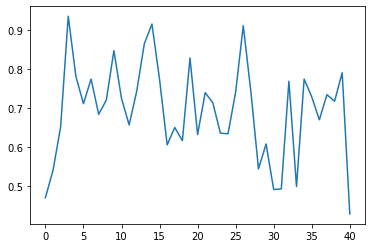

In [34]:
show_figure(q_check)
show_fig_tau(q_check)